In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import zscore, scoreatpercentile
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from joblib import dump
from joblib import load
import seaborn as sns
import matplotlib.pyplot as plt
import os

#PYOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.utils.utility import standardizer
from pyod.models.combination import average

joblibs_folder_name = 'Joblib'
joblib_file_name_pos_exploratorio = 'dados_pos_exploratorio.joblib'
joblib_file_name_pos_modelos = 'dados_pos_modelos.joblib'

base_data_path = 'Dados'

bold = '\033[1m'
end = '\033[0m'

sns.set(font_scale = 1.2)
sns.set_style('ticks')
a4_dims = (11.7, 8.27)
joblib_n_aih = 'dados_n_aih.joblib'

In [2]:
def calcula_zscore(dataset):
    def zscore(x):
        #calcula o desvio padrão
        sd = x.std()
        #evitando divisão por zero, se sd==0, acrescento 
        if math.isclose(sd, 0, rel_tol=1e-10): sd = 0.0000001
        #retorna (x-média)/(desvio-padrão)
        return (x-x.mean())/sd
        #return zscore(x)
    zscore_por_procedimento = dataset.groupby(['especialidade_leito'
                                               , 'obito'
                                               , 'carater_internacao'
                                               , 'porte_hospitalar'
                                               , 'internacao_com_UTI'
                                               , 'procedimento_realizado'
                                               , 'AIH_continuidade'
                                               , 'complexidade_alta'
                                               , 'tipo_unidade_62'
                                               , 'idade_maior_44'], as_index = True)['valor_total'].apply(zscore)
    #imputando 0 nos std que deram nan (N=1 e ddof=0 por default no pandas)
    zscore_por_procedimento.fillna(value=0, inplace=True)
    zscore_por_procedimento.rename("zscore", inplace=True)
    #Junção entre o dataframe dataset e dataframe 
    dataset = dataset.merge(right=zscore_por_procedimento, left_index=True, right_index=True, how='inner')
    return dataset

In [3]:
def calcula_outlier_IQR(dataset):
    def IQR(x):
        #calcula quantil 25
        Q1 = x.quantile(0.25)
        #calcula quantil 75
        Q3 = x.quantile(0.75)
        IQR = Q3 - Q1
        lista_outlier = []
        for index, value in x.items(): 
            if(value>Q3+(IQR*2)): 
                lista_outlier.append(1)
            else:
                lista_outlier.append(0)
        return pd.Series(lista_outlier, index = x.index) 
    # resultado do IQR outlier 
    IQR_por_procedimento = dataset.groupby(['especialidade_leito'
                                           , 'obito'
                                           , 'carater_internacao'
                                           , 'porte_hospitalar'
                                           , 'internacao_com_UTI'
                                           , 'procedimento_realizado'
                                           , 'AIH_continuidade'
                                           , 'complexidade_alta'
                                           , 'tipo_unidade_62'
                                           , 'idade_maior_44'], as_index = True)['valor_total'].apply(IQR)
    IQR_por_procedimento.rename("outlier_IQR", inplace=True)
    #Junção entre o dataframe dataset e dataframe 
    dataset = dataset.merge(right=IQR_por_procedimento, left_index=True, right_index=True, how='inner')
    return dataset

In [4]:
def get_groups(dataset):
    grupos = dataset.groupby(['especialidade_leito'
                               , 'obito'
                               , 'carater_internacao'
                               , 'porte_hospitalar'
                               , 'internacao_com_UTI'
                               , 'procedimento_realizado'
                               , 'AIH_continuidade'
                               , 'complexidade_alta'
                               , 'tipo_unidade_62'
                               , 'idade_maior_44'], as_index=True)['valor_total']
    return grupos

In [5]:
def plota_ridge(data, row, hue, y):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(data=data, row=row, hue=hue, aspect=15, height=.9, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, y,
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, y, clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, y)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

In [6]:
#carregando os dados que já foram tratados na análise exploratória
dados = load(os.path.join(base_data_path,joblibs_folder_name,joblib_file_name_pos_exploratorio))

In [7]:
dados.head()

,especialidade_leito,obito,carater_internacao,natureza_juridica_entidade_simplificada,porte_hospitalar,internacao_com_UTI,procedimento_realizado,valor_total,AIH_continuidade,complexidade_alta,tipo_unidade_62,idade_maior_44
0,1,0,02,1,MEDIO,0,0410010111,397.44,0,0,0,1
1,3,1,02,1,MEDIO,1,0303040165,1703.58,0,0,0,0
2,3,0,02,1,PEQUENO,0,0304100021,367.44,0,0,0,1
3,3,1,02,1,MEDIO,0,0304100021,479.56,0,0,0,1
4,3,1,02,1,MEDIO,0,0304100021,391.44,0,0,0,1


Vou calcular os outlier por Zscore e por IQR, para cada conjunto de dados, agrupados por todas as minhas features, exceto valor_total. Com isso, teremos outliers univariáveis, observando valor_total, considerando que cada grupo contém observações razoavelmente semelhantes, dada a análise exploratória já realizada.

In [15]:
dados = calcula_zscore(dados)

In [16]:
dados = calcula_outlier_IQR(dados)

Com essa informação em mãos, iremos verificar o percentual de outliers pelos 2 critérios, IQR*1.5 e Zscore>2

In [17]:
outliers = np.all([[True if zscore > 3 else False for zscore in dados['zscore']],
                  [True if outlier_IQR == 1 else False for outlier_IQR in dados['outlier_IQR']]], 
                 axis=0)

In [18]:
dados['outliers_IQR_zscore'] = outliers
dados['outliers_IQR_zscore'] = dados['outliers_IQR_zscore'].astype('category')
dados['outliers_IQR_zscore'].cat.rename_categories({True: 1, False: 0}, inplace=True)

In [21]:
dados.shape

(318916, 15)

In [22]:
#pegando os meus labels de grupos e dataframes respectivos
grupos = get_groups(dados)

In [23]:
len(grupos)

8755

In [24]:
#filtrando apenas os grupos com mais de 100 observações
grupos_maiores_100 = {nome:grupo for nome, grupo in grupos if grupo.shape[0]>100}
#ordenando-os pela quantidade de observações em cada dataframe, decrescentemente.
grupos_maiores_100_ordenado_len = dict(sorted(grupos_maiores_100.items(), key=lambda item: len(item[1]) ,reverse=True))
grupos_maiores_100_ordenado_mediana = dict(sorted(grupos_maiores_100.items(), key=lambda item: item[1].median() ,reverse=True))
grupos_maiores_100_ordenado_media = dict(sorted(grupos_maiores_100.items(), key=lambda item: item[1].mean() ,reverse=True))

In [25]:
len(grupos_maiores_100_ordenado_len)

482

In [26]:
grupos_maiores_100_ordenado_len

{(2,
  0,
  '02',
  'MEDIO',
  0,
  '0411010034',
  0,
  0,
  0,
  0): 80297     545.73
 112281    757.69
 161033    767.24
 161589    735.49
 161633    735.49
            ...  
 301931    740.18
 302177    678.11
 302360    740.18
 302739    740.18
 320002    724.49
 Name: valor_total, Length: 17271, dtype: float64,
 (2,
  0,
  '02',
  'MEDIO',
  0,
  '0310010039',
  0,
  0,
  0,
  0): 158194    561.28
 158195    553.28
 158197    609.40
 158198    561.28
 158199    681.52
            ...  
 318521    628.48
 319955    515.60
 319956    500.80
 319957    506.60
 319958    514.60
 Name: valor_total, Length: 16286, dtype: float64,
 (2,
  0,
  '02',
  'GRANDE',
  0,
  '0310010039',
  0,
  0,
  0,
  0): 37962     577.62
 165379    654.13
 165380    747.41
 165381    561.63
 165382    561.63
            ...  
 301807    574.98
 302205    566.98
 302353    657.43
 302354    575.98
 318518    571.28
 Name: valor_total, Length: 10900, dtype: float64,
 (2,
  0,
  '02',
  'GRANDE',
  0,
  '0411

In [27]:
grupo1 = dados.loc[list(grupos_maiores_100_ordenado_len.get(((2,  0,  '02',  'MEDIO',  0,  '0411010034',  0,  0,  0,  0))).index),]
grupo2 = dados.loc[list(grupos_maiores_100_ordenado_len.get(((2,  0,  '02',  'MEDIO',  0,  '0310010039',  0,  0,  0,  0))).index),]
grupo3 = dados.loc[list(grupos_maiores_100_ordenado_len.get(((2,  0,  '02',  'GRANDE',  0,  '0411010026',  0,  0,  0,  0))).index),]
grupo4 = dados.loc[list(grupos_maiores_100_ordenado_len.get(((3,  0,  '02',  'MEDIO',  0,  '0303140151',  0,  0,  0,  1))).index),]
grupo5 = dados.loc[list(grupos_maiores_100_ordenado_len.get(((2,  0,  '02',  'GRANDE',  0,  '0310010047',  0,  0,  0,  0))).index),]
grupo6 = dados.loc[list(grupos_maiores_100_ordenado_len.get(((2,  0,  '02',  'GRANDE',  0,  '0411020013',  0,  0,  0,  0))).index),]
grupo7 = dados.loc[list(grupos_maiores_100_ordenado_len.get(((3,  0,  '02',  'GRANDE',  0,  '0303100044',  0,  0,  0,  0))).index),]

Qtd internações = 17271
Qtd outliers = 83
Qtd outliers de natureza juridica 2 ou 3 = 12


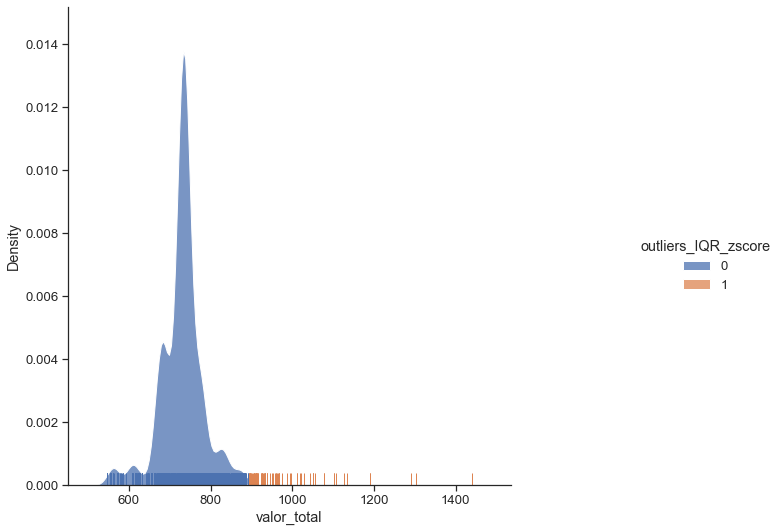

In [28]:
sns.set_style('ticks')
g = sns.displot(grupo1, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo1.shape[0]}')
print(f'Qtd outliers = {grupo1[grupo1.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo1.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 16286
Qtd outliers = 132
Qtd outliers de natureza juridica 2 ou 3 = 5


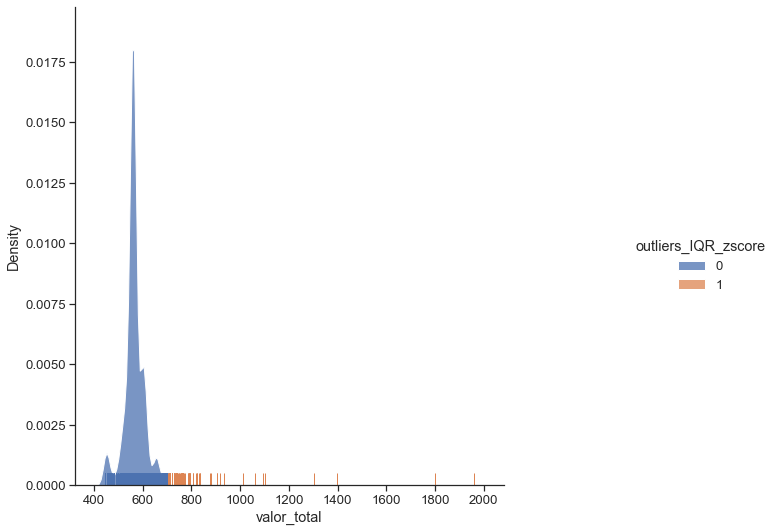

In [29]:
sns.set_style('ticks')
g = sns.displot(grupo2, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo2.shape[0]}')
print(f'Qtd outliers = {grupo2[grupo2.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo2.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 8023
Qtd outliers = 148
Qtd outliers de natureza juridica 2 ou 3 = 36


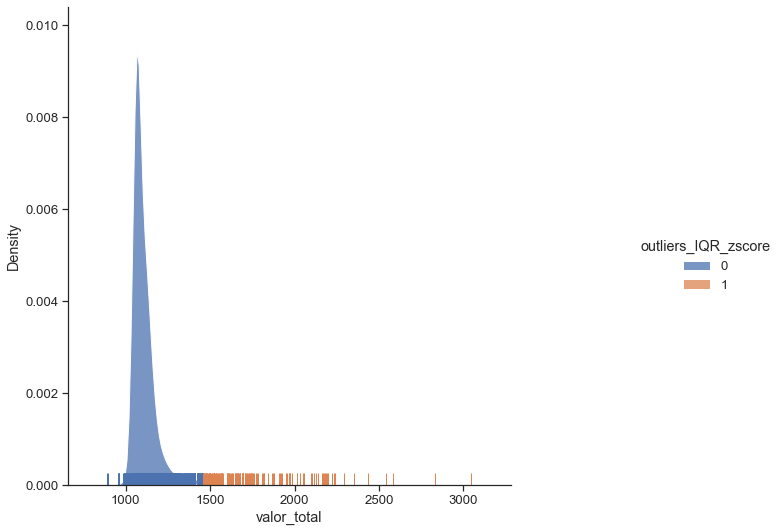

In [30]:
sns.set_style('ticks')
g = sns.displot(grupo3, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo3.shape[0]}')
print(f'Qtd outliers = {grupo3[grupo3.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo3.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 5495
Qtd outliers = 135
Qtd outliers de natureza juridica 2 ou 3 = 120


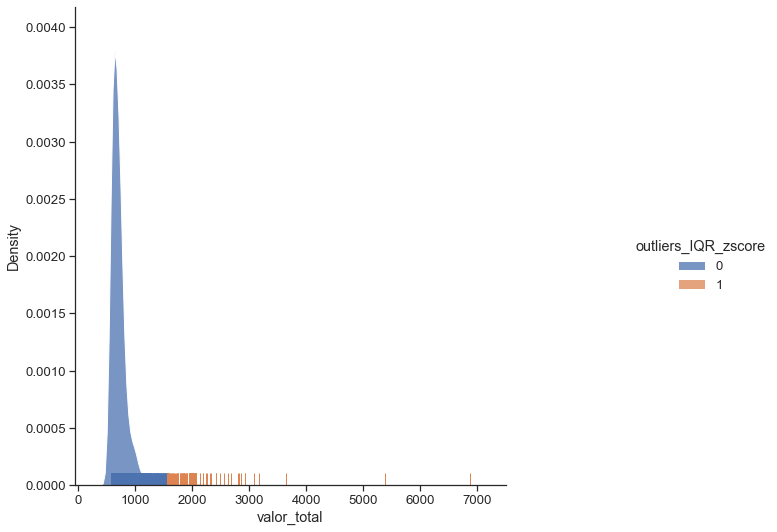

In [31]:
sns.set_style('ticks')
g = sns.displot(grupo4, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo4.shape[0]}')
print(f'Qtd outliers = {grupo4[grupo4.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo4.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 5214
Qtd outliers = 76
Qtd outliers de natureza juridica 2 ou 3 = 15


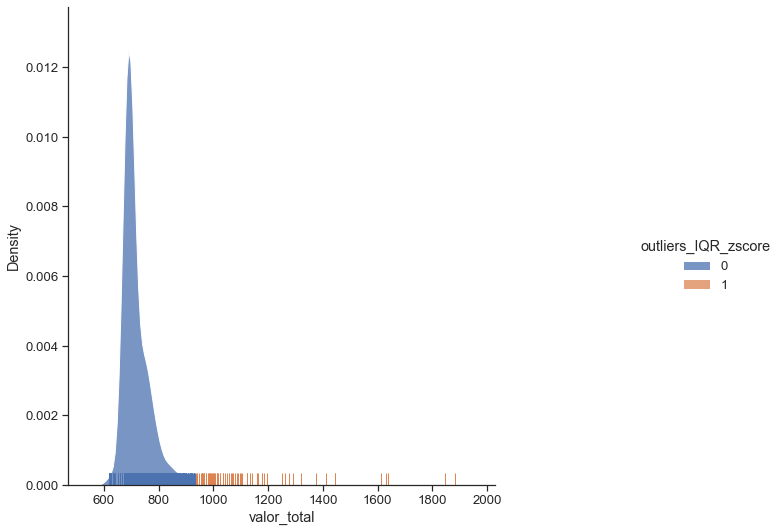

In [32]:
sns.set_style('ticks')
g = sns.displot(grupo5, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo5.shape[0]}')
print(f'Qtd outliers = {grupo5[grupo5.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo5.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 3037
Qtd outliers = 26
Qtd outliers de natureza juridica 2 ou 3 = 6


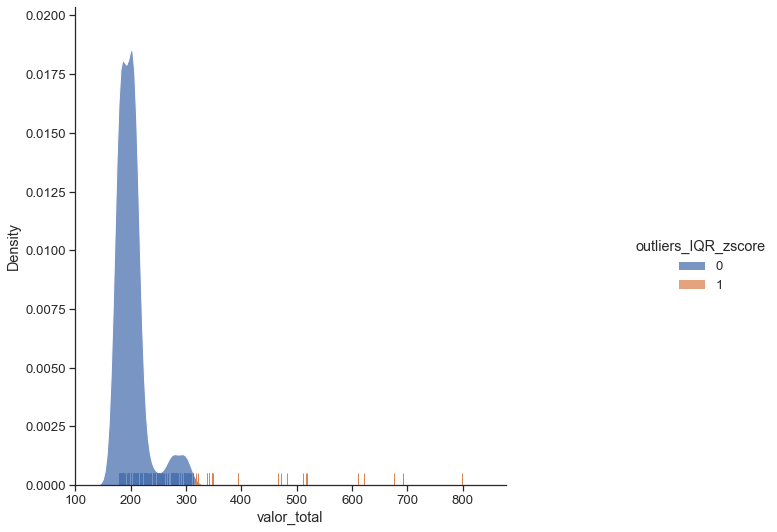

In [33]:
sns.set_style('ticks')
g = sns.displot(grupo6, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo6.shape[0]}')
print(f'Qtd outliers = {grupo6[grupo6.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo6.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 2965
Qtd outliers = 56
Qtd outliers de natureza juridica 2 ou 3 = 8


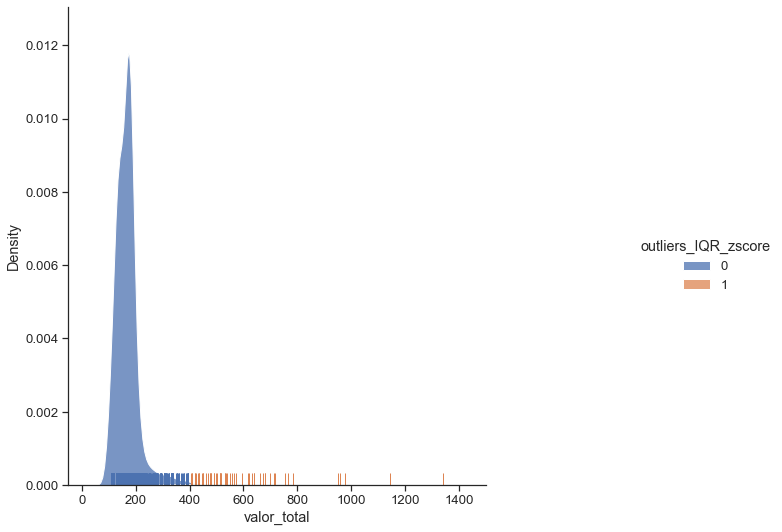

In [34]:
sns.set_style('ticks')
g = sns.displot(grupo7, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo7.shape[0]}')
print(f'Qtd outliers = {grupo7[grupo7.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo7.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

### Agora vamos para os grupos ordenados pela mediana (desc)

In [35]:
grupos_maiores_100_ordenado_mediana

{(1,
  0,
  '01',
  'MEDIO',
  1,
  '0406010935',
  0,
  1,
  0,
  1): 46121     15971.60
 46124     15682.70
 46125     16926.64
 46126     15589.37
 46127     18554.28
             ...   
 118957    17830.02
 118962    13299.66
 118963    16611.54
 118964    13134.25
 142616    19157.22
 Name: valor_total, Length: 158, dtype: float64,
 (1,
  0,
  '02',
  'GRANDE',
  1,
  '0415010012',
  0,
  1,
  0,
  1): 7173       9067.26
 7175      22216.09
 7179      12561.02
 7191       8943.71
 7203       8173.70
             ...   
 298314    20480.67
 298315    21157.50
 298318    16547.07
 299102    17875.30
 309546    14803.26
 Name: valor_total, Length: 130, dtype: float64,
 (1,
  0,
  '02',
  'MEDIO',
  1,
  '0406010935',
  0,
  1,
  0,
  1): 14301     16058.22
 14303     15761.76
 14342     14319.55
 14369     15335.42
 14400     21323.08
             ...   
 142197    17797.64
 142208    18540.25
 142210    14052.56
 142211    11512.79
 258493    15746.29
 Name: valor_total, Length: 319

In [36]:
grupo1_mediana = dados.loc[list(grupos_maiores_100_ordenado_mediana.get(((1,  0,  '01',  'MEDIO',  1,  '0406010935',  0,  1,  0,  1))).index),]
grupo2_mediana = dados.loc[list(grupos_maiores_100_ordenado_mediana.get(((1,  0,  '02',  'GRANDE',  1,  '0415010012',  0,  1,  0, 1))).index),]
grupo3_mediana = dados.loc[list(grupos_maiores_100_ordenado_mediana.get(((3,  1,  '01',  'MEDIO',  1,  '0303010223',  0,  0,  0,  1))).index),]
grupo4_mediana = dados.loc[list(grupos_maiores_100_ordenado_mediana.get(((1,  0,  '01',  'MEDIO',  1,  '0415020050',  0,  1,  0,  1))).index),]
grupo5_mediana = dados.loc[list(grupos_maiores_100_ordenado_mediana.get(((1,  0,  '02',  'MEDIO',  1,  '0406030022',  0,  1,  0,  1))).index),]
grupo6_mediana = dados.loc[list(grupos_maiores_100_ordenado_mediana.get(((3,  0,  '02',  'MEDIO',  0,  '0304080039',  0,  1,  0,  0))).index),]
grupo7_mediana = dados.loc[list(grupos_maiores_100_ordenado_mediana.get(((1,  0,  '02',  'PEQUENO',  1,  '0406010650',  0,  1,  0,  1))).index),]

Qtd internações = 158
Qtd outliers = 4
Qtd outliers de natureza juridica 2 ou 3 = 4


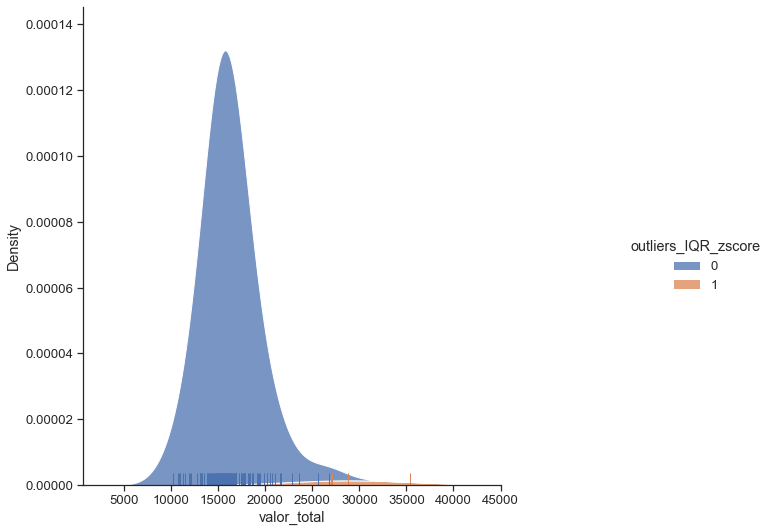

In [37]:
sns.set_style('ticks')
g = sns.displot(grupo1_mediana, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo1_mediana.shape[0]}')
print(f'Qtd outliers = {grupo1_mediana[grupo1_mediana.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo1_mediana.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 130
Qtd outliers = 0
Qtd outliers de natureza juridica 2 ou 3 = 0


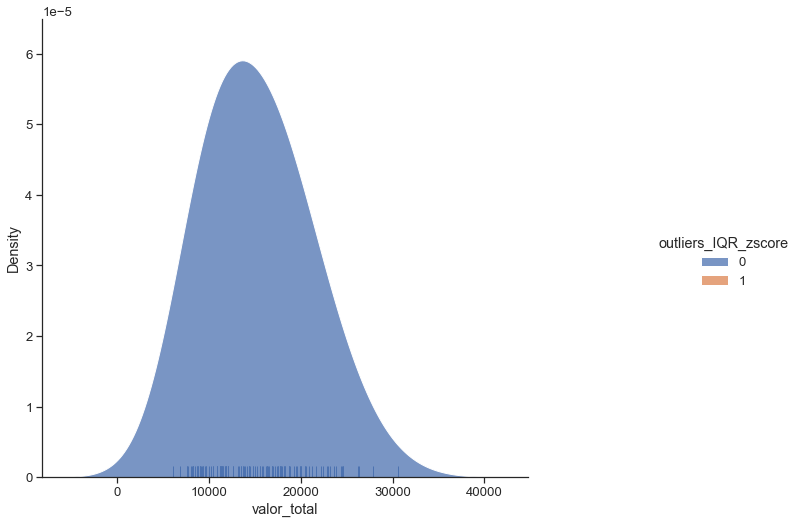

In [38]:
sns.set_style('ticks')
g = sns.displot(grupo2_mediana, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo2_mediana.shape[0]}')
print(f'Qtd outliers = {grupo2_mediana[grupo2_mediana.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo2_mediana.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 309
Qtd outliers = 6
Qtd outliers de natureza juridica 2 ou 3 = 0


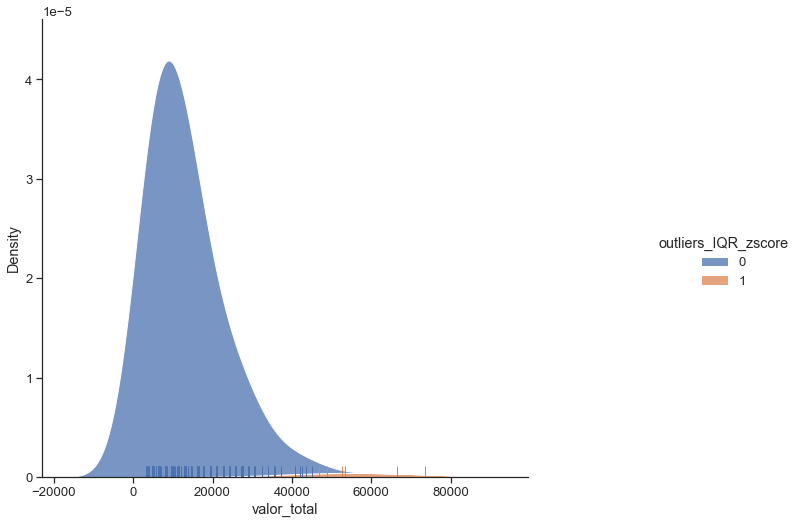

In [39]:
sns.set_style('ticks')
g = sns.displot(grupo3_mediana, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo3_mediana.shape[0]}')
print(f'Qtd outliers = {grupo3_mediana[grupo3_mediana.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo3_mediana.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 314
Qtd outliers = 3
Qtd outliers de natureza juridica 2 ou 3 = 3


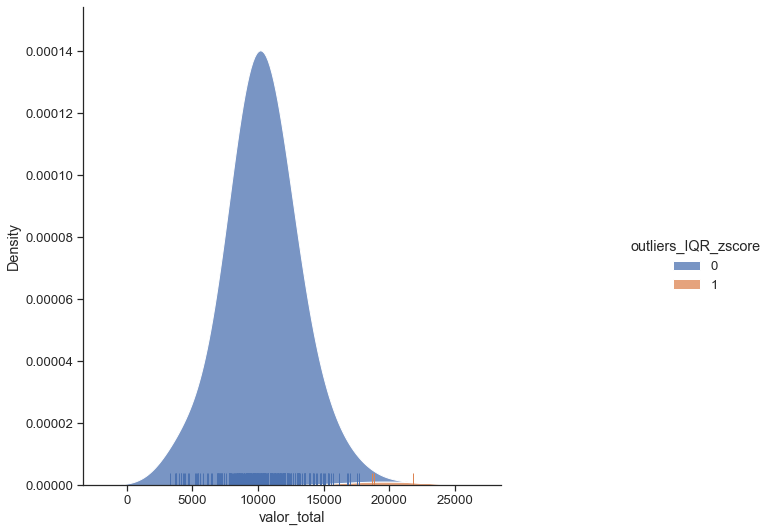

In [40]:
sns.set_style('ticks')
g = sns.displot(grupo4_mediana, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo4_mediana.shape[0]}')
print(f'Qtd outliers = {grupo4_mediana[grupo4_mediana.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo4_mediana.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 110
Qtd outliers = 2
Qtd outliers de natureza juridica 2 ou 3 = 2


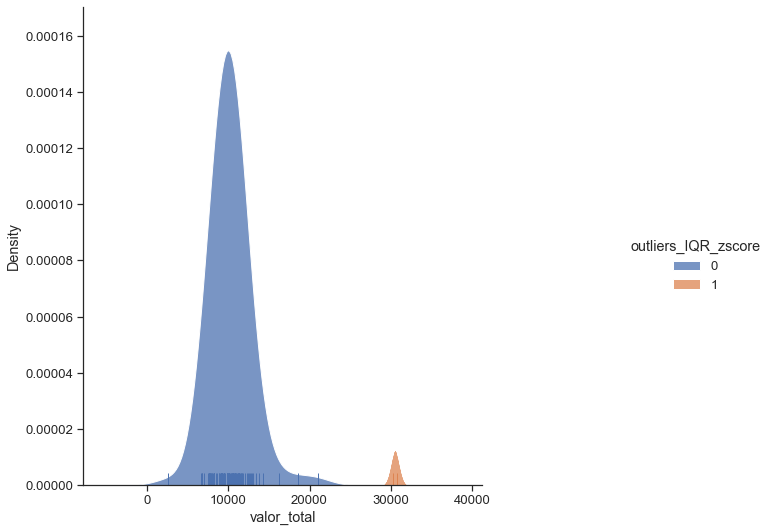

In [41]:
sns.set_style('ticks')
g = sns.displot(grupo5_mediana, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo5_mediana.shape[0]}')
print(f'Qtd outliers = {grupo5_mediana[grupo5_mediana.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo5_mediana.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 104
Qtd outliers = 0
Qtd outliers de natureza juridica 2 ou 3 = 0


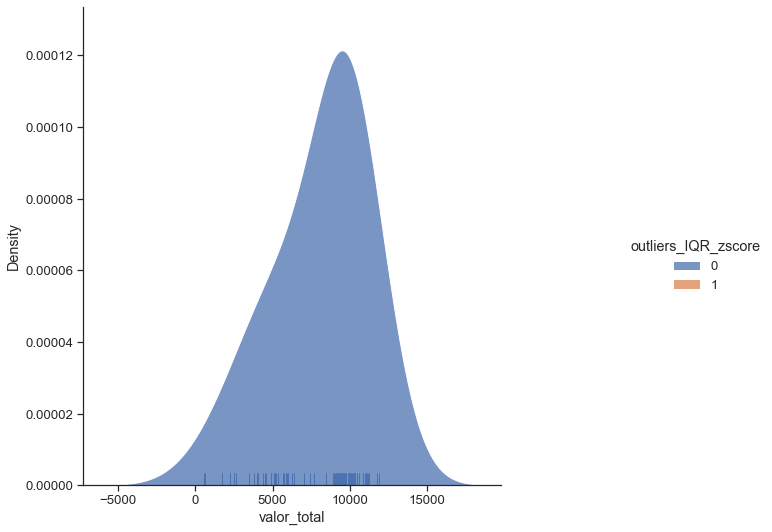

In [42]:
sns.set_style('ticks')
g = sns.displot(grupo6_mediana, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo6_mediana.shape[0]}')
print(f'Qtd outliers = {grupo6_mediana[grupo6_mediana.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo6_mediana.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 133
Qtd outliers = 3
Qtd outliers de natureza juridica 2 ou 3 = 3


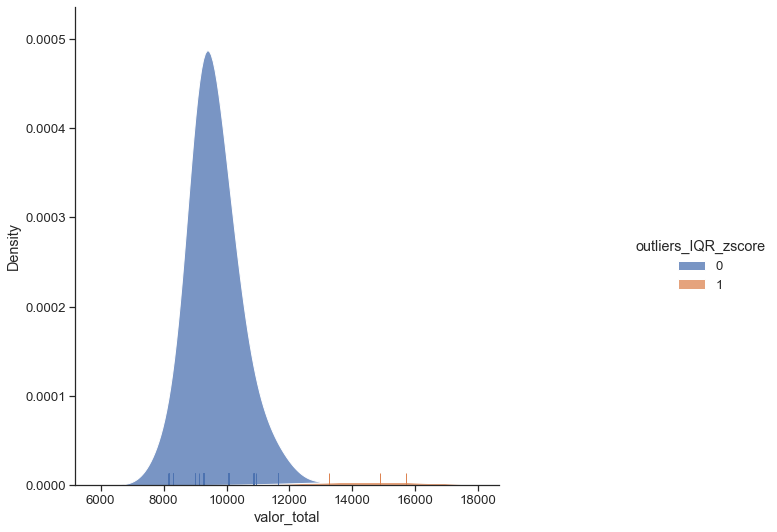

In [43]:
sns.set_style('ticks')
g = sns.displot(grupo7_mediana, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo7_mediana.shape[0]}')
print(f'Qtd outliers = {grupo7_mediana[grupo7_mediana.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo7_mediana.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

### Vamos agora para os grupos ordenados pela média (desc)

In [44]:
grupos_maiores_100_ordenado_media

{(1,
  0,
  '01',
  'MEDIO',
  1,
  '0406010935',
  0,
  1,
  0,
  1): 46121     15971.60
 46124     15682.70
 46125     16926.64
 46126     15589.37
 46127     18554.28
             ...   
 118957    17830.02
 118962    13299.66
 118963    16611.54
 118964    13134.25
 142616    19157.22
 Name: valor_total, Length: 158, dtype: float64,
 (1,
  0,
  '02',
  'GRANDE',
  1,
  '0415010012',
  0,
  1,
  0,
  1): 7173       9067.26
 7175      22216.09
 7179      12561.02
 7191       8943.71
 7203       8173.70
             ...   
 298314    20480.67
 298315    21157.50
 298318    16547.07
 299102    17875.30
 309546    14803.26
 Name: valor_total, Length: 130, dtype: float64,
 (1,
  0,
  '02',
  'MEDIO',
  1,
  '0406010935',
  0,
  1,
  0,
  1): 14301     16058.22
 14303     15761.76
 14342     14319.55
 14369     15335.42
 14400     21323.08
             ...   
 142197    17797.64
 142208    18540.25
 142210    14052.56
 142211    11512.79
 258493    15746.29
 Name: valor_total, Length: 319

In [45]:
grupo1_media = dados.loc[list(grupos_maiores_100_ordenado_media.get(((1,  0,  '01',  'MEDIO',  1,  '0406010935',  0,  1,  0,  1))).index),]
grupo2_media = dados.loc[list(grupos_maiores_100_ordenado_media.get(((1,  0,  '02',  'GRANDE',  1,  '0415010012',  0,  1,  0,  1))).index),]
grupo3_media = dados.loc[list(grupos_maiores_100_ordenado_media.get(((3,  1,  '01',  'MEDIO',  1,  '0303010223',  0,  0,  0,  1))).index),]
grupo4_media = dados.loc[list(grupos_maiores_100_ordenado_media.get(((1,  0,  '02',  'MEDIO',  1,  '0406030022',  0,  1,  0,  1))).index),]
grupo5_media = dados.loc[list(grupos_maiores_100_ordenado_media.get(((1,  0,  '01',  'MEDIO',  1,  '0415020050',  0,  1,  0,  1))).index),]
grupo6_media = dados.loc[list(grupos_maiores_100_ordenado_media.get(((1,  0,  '02',  'PEQUENO',  1,  '0406010650',  0,  1,  0,  1))).index),]
grupo7_media = dados.loc[list(grupos_maiores_100_ordenado_media.get(((7,  0,  '02',  'GRANDE',  1,  '0303160063',  0,  0,  0,  0))).index),]

Qtd internações = 158
Qtd outliers = 4
Qtd outliers de natureza juridica 2 ou 3 = 4


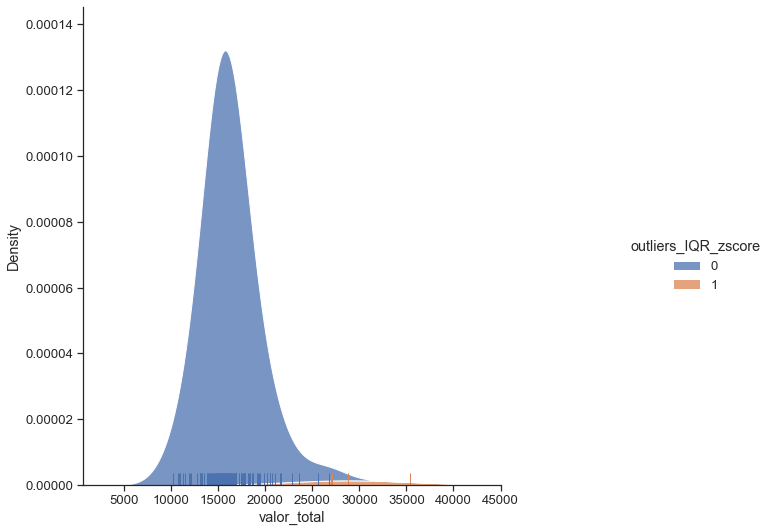

In [46]:
sns.set_style('ticks')
g = sns.displot(grupo1_media, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo1_media.shape[0]}')
print(f'Qtd outliers = {grupo1_media[grupo1_media.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo1_media.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 130
Qtd outliers = 0
Qtd outliers de natureza juridica 2 ou 3 = 0


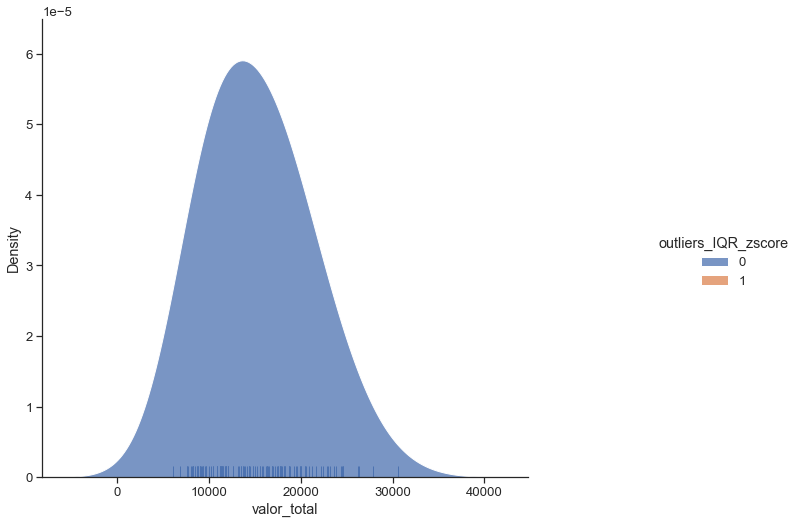

In [47]:
sns.set_style('ticks')
g = sns.displot(grupo2_media, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo2_media.shape[0]}')
print(f'Qtd outliers = {grupo2_media[grupo2_media.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo2_media.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 309
Qtd outliers = 6
Qtd outliers de natureza juridica 2 ou 3 = 0


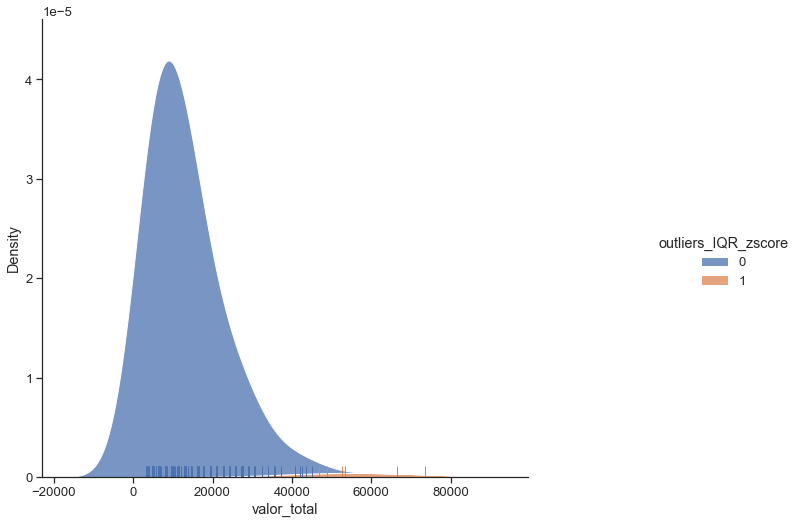

In [48]:
sns.set_style('ticks')
g = sns.displot(grupo3_media, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo3_media.shape[0]}')
print(f'Qtd outliers = {grupo3_media[grupo3_media.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo3_media.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 110
Qtd outliers = 2
Qtd outliers de natureza juridica 2 ou 3 = 2


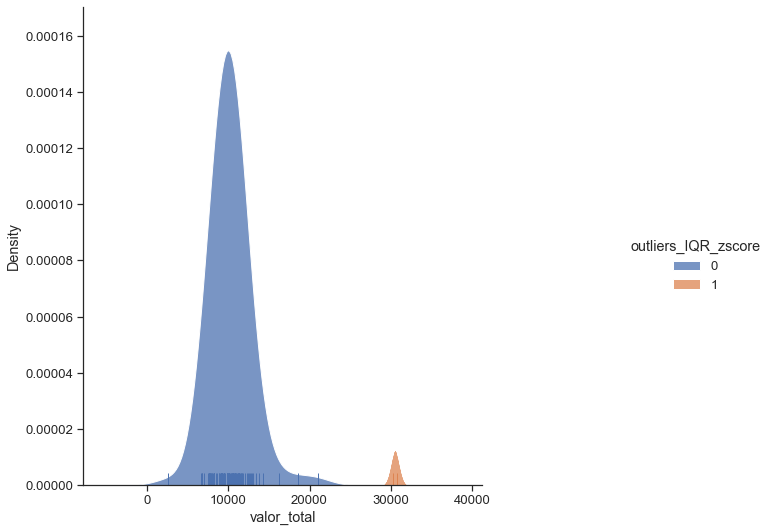

In [49]:
sns.set_style('ticks')
g = sns.displot(grupo4_media, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo4_media.shape[0]}')
print(f'Qtd outliers = {grupo4_media[grupo4_media.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo4_media.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 314
Qtd outliers = 3
Qtd outliers de natureza juridica 2 ou 3 = 3


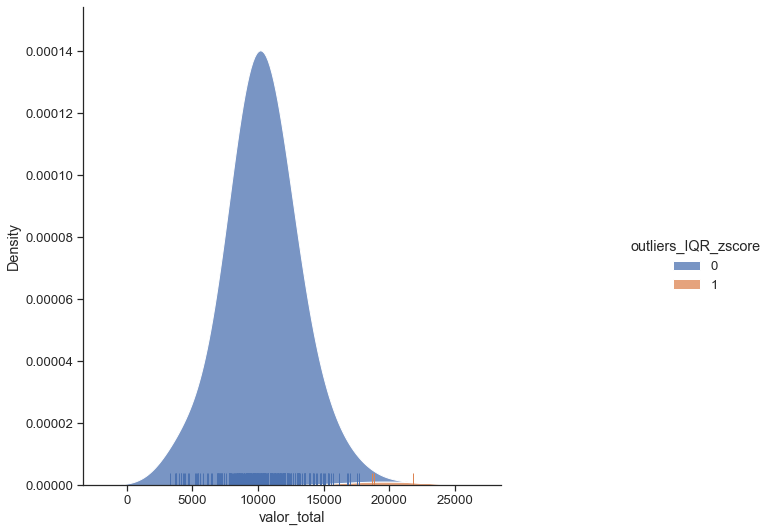

In [50]:
sns.set_style('ticks')
g = sns.displot(grupo5_media, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo5_media.shape[0]}')
print(f'Qtd outliers = {grupo5_media[grupo5_media.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo5_media.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 133
Qtd outliers = 3
Qtd outliers de natureza juridica 2 ou 3 = 3


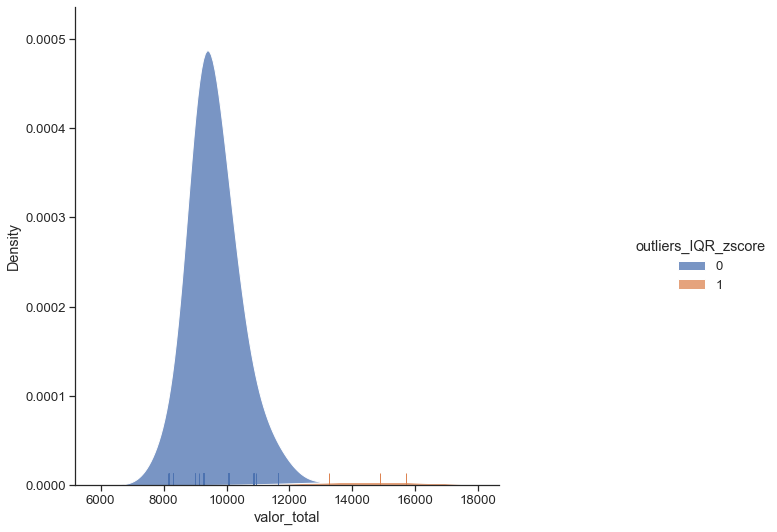

In [51]:
sns.set_style('ticks')
g = sns.displot(grupo6_media, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo6_media.shape[0]}')
print(f'Qtd outliers = {grupo6_media[grupo6_media.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo6_media.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

Qtd internações = 436
Qtd outliers = 4
Qtd outliers de natureza juridica 2 ou 3 = 0


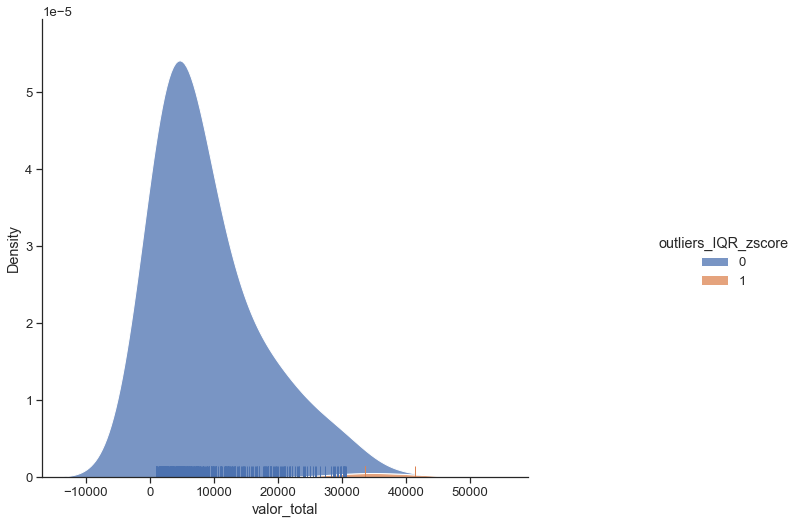

In [52]:
sns.set_style('ticks')
g = sns.displot(grupo7_media, x='valor_total', hue='outliers_IQR_zscore', kind='kde',bw_adjust=2, multiple="stack", rug=True)
g.fig.set_size_inches(a4_dims)
sns.despine()
print(f'Qtd internações = {grupo7_media.shape[0]}')
print(f'Qtd outliers = {grupo7_media[grupo7_media.outliers_IQR_zscore==1].shape[0]}')
print(f'Qtd outliers de natureza juridica 2 ou 3 = {grupo7_media.query("outliers_IQR_zscore==1 and ~(natureza_juridica_entidade_simplificada==1)").shape[0]}')

### Após a detecção de outliers, vamos agora resgatar algumas internações para análise individualizada.

In [53]:
#carregando o dataset com os números das AIH e índices para resgatá-la no detalhe.
n_aih_indices = load(os.path.join(base_data_path,joblibs_folder_name,joblib_n_aih))

In [54]:
# segundo outlier do grupo 4 ordenado por qtd de elementos.
# pesquisar a AIH no CGUDATA
nat_jur_privada = [2,3]
n_aih_indices.iloc[grupo4.query('outliers_IQR_zscore==1 and natureza_juridica_entidade_simplificada == @nat_jur_privada').sort_values(by='valor_total', ascending=False).iloc[1].name]

N_AIH    2519101961090
Name: 88602, dtype: object

In [55]:
n_aih_indices.iloc[grupo4[grupo4.valor_total==grupo4.valor_total.median()].iloc[0].name]

N_AIH    2519100209868
Name: 9321, dtype: object

In [56]:
n_aih_indices.iloc[grupo1_mediana.query('outliers_IQR_zscore==1 and natureza_juridica_entidade_simplificada == @nat_jur_privada').sort_values(by='valor_total', ascending=False).iloc[0:4,].index.values]

,N_AIH
46130,2518100615866
46201,2519101261116
118937,2520100277134
118942,2520100264924


In [57]:
n_aih_indices.iloc[grupo1_mediana.query('valor_total >15770 and valor_total<15780').index.values[0]]

N_AIH    2519100841257
Name: 118891, dtype: object

In [58]:
n_aih_indices.iloc[grupo5_mediana.query('outliers_IQR_zscore==1 and natureza_juridica_entidade_simplificada == @nat_jur_privada').sort_values(by='valor_total', ascending=False).iloc[0:4,].index.values]

,N_AIH
50120,2519100176043
50813,2520100382932


In [59]:
n_aih_indices.iloc[grupo5_mediana.query('valor_total >10080 and valor_total<10120').index.values[0]]

N_AIH    2519100718651
Name: 50548, dtype: object

### Dados para a Conclusão

In [60]:
#qtd outliers
(dados.outliers_IQR_zscore==1).sum()

4204

In [38]:
outliers_fraction = dados['outliers_IQR_zscore'].value_counts(normalize=True).loc[1]